# PMF for Recommender Systems

This is an implementation for Probabilistic Matrix Factorisation. We have made use of a subset of the IMDB dataset for training purposes.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

Let's now download our dataset. We will also unzip it for further use.

In [0]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2020-05-05 16:44:24--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   974KB/s    in 1.0s    

2020-05-05 16:44:25 (974 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Let's take a look at part of the ratings file to get an idea of the columns available.

In [0]:
df = pd.read_csv('ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


As part of the dataset, there is also another file that contains movie information, which includes the movie id, the title, the genre, among others. We can INNER JOIN the ratings and movies datasets to gain access to all data we will need for our analysis.

In [0]:
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_join = pd.merge(df_movies, df, how='inner', on='movieId')
df_join.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


Let's now prepare our sparse review matrix. For this purpose, we first need to find out how many users and movies we have in our dataset. Additionally, we will set S to 5 dimensions.

In [0]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 3])
    uniq_movies = np.unique(df_values[:, 0])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = movie_to_column[row.movieId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column

Let's now call this function and retrieve all necessary parameters.

In [0]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df_join, 0.8)
parameters = {}

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [0]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [0]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

Now let's implement the Log-a posteriori:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [0]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [0]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [0]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

For the purposes of scaling, we need the maximum and minimum rating values.

In [0]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [0]:
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

Let's train our model!

In [0]:
log_ps, rmse_train, rmse_test = train(150)

Log p a-posteriori at iteration 10 : -47315.01695753759
Log p a-posteriori at iteration 20 : -26049.43854684034
Log p a-posteriori at iteration 30 : -18661.49545924417
Log p a-posteriori at iteration 40 : -15071.180100170577
Log p a-posteriori at iteration 50 : -13079.762498741024
Log p a-posteriori at iteration 60 : -11893.64153224053
Log p a-posteriori at iteration 70 : -11160.963307065578
Log p a-posteriori at iteration 80 : -10704.998944575167
Log p a-posteriori at iteration 90 : -10404.727479137038
Log p a-posteriori at iteration 100 : -10201.562115083421
Log p a-posteriori at iteration 110 : -10056.94029740754
Log p a-posteriori at iteration 120 : -9947.130125510244
Log p a-posteriori at iteration 130 : -9861.603527161862
Log p a-posteriori at iteration 140 : -9797.336507154727
Log p a-posteriori at iteration 150 : -9750.831386678909


Now let's take a look at some graphs

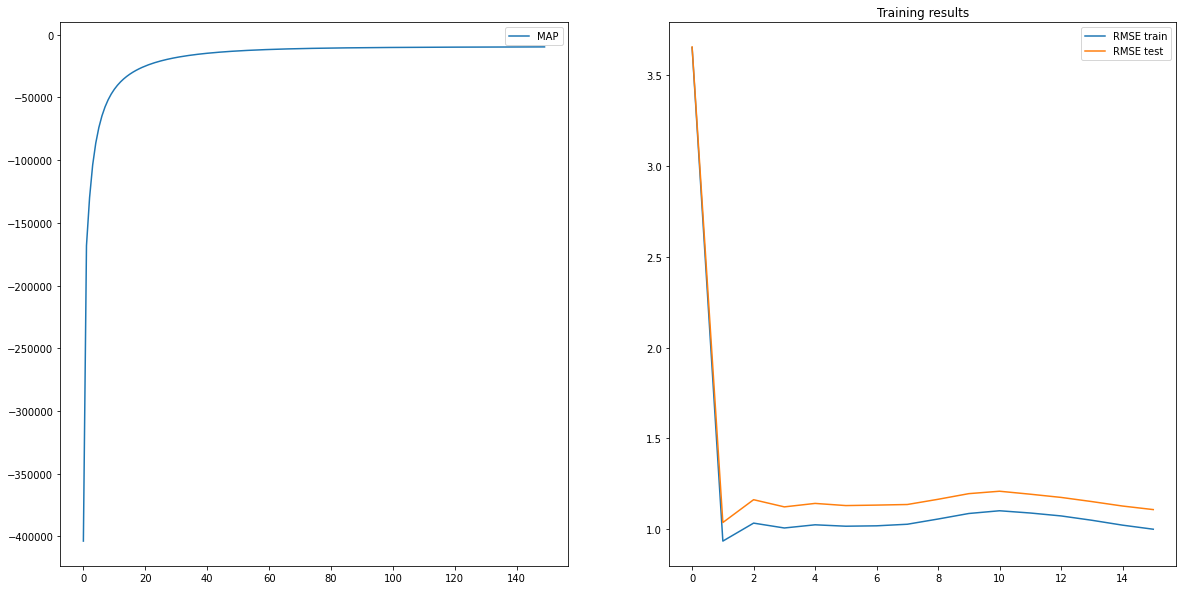

In [0]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

Let's now evaluate our model on both the training and testing sets.

In [0]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 1.0002025748958006
RMSE of testing set: 1.108309473614627


Now we will pick a user from the database and look at his/her preferences.

In [0]:
user_id = 45
df_join[df_join['userId'] == user_id].sort_values(by=['rating'], ascending=False).head(10)

,movieId,title,genres,userId,rating,timestamp
39202,2078,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical,45,5.0,950726248
46609,2694,Big Daddy (1999),Comedy,45,5.0,951170525
46142,2657,"Rocky Horror Picture Show, The (1975)",Comedy|Horror|Musical|Sci-Fi,45,5.0,950741248
55533,3578,Gladiator (2000),Action|Adventure|Drama,45,5.0,1020803425
33101,1584,Contact (1997),Drama|Sci-Fi,45,5.0,950740871
56625,3717,Gone in 60 Seconds (2000),Action|Crime,45,5.0,1007994717
45369,2580,Go (1999),Comedy|Crime,45,5.0,951756858
56996,3753,"Patriot, The (2000)",Action|Drama|War,45,5.0,1007995101
57287,3793,X-Men (2000),Action|Adventure|Sci-Fi,45,5.0,1007995171
57418,3798,What Lies Beneath (2000),Drama|Horror|Mystery,45,5.0,1007995171


Let's look at the least preferred items.

In [0]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)

,movieId,title,genres,userId,rating,timestamp
53154,3270,"Cutting Edge, The (1992)",Comedy|Drama|Romance,45,1.0,950718581
5111,173,Judge Dredd (1995),Action|Crime|Sci-Fi,45,1.0,950741335
44072,2470,Crocodile Dundee (1986),Adventure|Comedy,45,1.0,950740565
67895,5585,Ernest Scared Stupid (1991),Comedy,45,1.0,1034344038
62486,4502,Ernest Saves Christmas (1988),Children|Comedy,45,1.0,1034344018
60222,4104,Ernest Goes to Camp (1987),Comedy,45,1.0,1034344018
53115,3268,Stop! Or My Mom Will Shoot (1992),Action|Comedy,45,1.0,950740376
46306,2672,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller,45,1.0,950741061
54299,3439,Teenage Mutant Ninja Turtles II: The Secret of...,Action|Children|Fantasy,45,1.0,1034344018
15160,569,Little Big League (1994),Comedy|Drama,45,2.0,950722240


Let's now look at the most likely preferences of the selected user.

In [0]:
predictions = np.zeros((n_movies, 1))
movie_to_column_items = np.array(list(movie_to_column.items()))
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])

for i, movie in enumerate(movie_to_column_items):
    predictions[i] = predict(user_id, movie[0])
    
indices = np.argsort(-predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Movie,Genres,Prediction
0,45,417,Barcelona (1994),Comedy|Romance,3.562902
1,45,27611,Battlestar Galactica (2003),Drama|Sci-Fi|War,3.555125
2,45,3969,Pay It Forward (2000),Drama,3.548344
3,45,104841,Gravity (2013),Action|Sci-Fi|IMAX,3.546065
4,45,1754,Fallen (1998),Crime|Drama|Fantasy|Thriller,3.542547
5,45,114180,"Maze Runner, The (2014)",Action|Mystery|Sci-Fi,3.541998
6,45,5785,Jackass: The Movie (2002),Action|Comedy|Documentary,3.526598
7,45,1755,Shooting Fish (1997),Comedy|Romance,3.515884
8,45,1711,Midnight in the Garden of Good and Evil (1997),Crime|Drama|Mystery,3.500507
9,45,177765,Coco (2017),Adventure|Animation|Children,3.495129


Now the predictions for least preferred items.

In [0]:
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])
indices = np.argsort(predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Movie,Genres,Prediction
0,45,2901,Phantasm (1979),Horror|Sci-Fi,2.054488
1,45,3104,Midnight Run (1988),Action|Comedy|Crime|Thriller,2.220623
2,45,26761,Prime Suspect 2 (1992),Crime|Drama|Mystery|Romance|Thriller,2.227821
3,45,96518,Prime Suspect 6: The Last Witness (2003),Drama|Thriller,2.227821
4,45,160422,The Wooden Horse (1950),Drama|War,2.227821
5,45,121099,101 Dalmatians II: Patch's London Adventure (2...,Animation|Children,2.237293
6,45,165489,Ethel & Ernest (2016),(no genres listed),2.237293
7,45,96520,Prime Suspect: The Lost Child (1995),Drama|Mystery,2.246765
8,45,93740,Salmon Fishing in the Yemen (2011),Comedy|Drama|Romance,2.256236
9,45,91414,Arthur Christmas (2011),Animation|Children|Comedy|Drama,2.275180


I hope you enjoyed this exercise. Something you can also try on your own is to implement gradient descent instead of MAP-estimation like I did here. Let me know about any comments you may have.